# Web Scraping - Anran Zhao

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it. I look at used cars below.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/rva?purveyor=owner#search=1~gallery~0~0' # I chose RVs
raw = requests.get(url,headers=header)

## 2. Get your search results of interest and extract data from them, using code similar to what's below.

In [14]:
from bs4 import BeautifulSoup as soup
bsObj = soup(raw.content,'html.parser')
listings = bsObj.find_all(class_="cl-static-search-result")

In [18]:
import re
import numpy as np

brands = ['thor', 'airstream', 'forest river', 'winnebago', 'coachman', 'jayco', 'keystone',
          'roadtrek', 'lance', 'gmc', 'catalina', 'pioneer']

data = []

for k in range(len(listings)):
    title = listings[k].find('div', class_='title').get_text().lower()
    price = listings[k].find('div', class_='price').get_text()
    link = listings[k].find(href=True)['href']

    words = title.split()
    hits = [word for word in words if word in brands]
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]

    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title)
    if regex_search is None:
        year = np.nan
    else:
        year = regex_search.group(0)

    data.append({'title': title, 'price': price, 'year': year, 'link': link, 'brand': brand})

## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.

In [20]:
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('craigslist_cville_RVs.csv')
df.head()

(11, 6)


,title,price,year,link,brand,age
0,2016 thor freedom elite 23h,45000,2016.0,https://charlottesville.craigslist.org/rvs/d/w...,thor,9.0
1,2005 airstream 28' international ccd,42500,2005.0,https://charlottesville.craigslist.org/rvs/d/s...,airstream,20.0
2,2017 forest river rpod 176 (bunks!) (2017.5),15000,2017.0,https://charlottesville.craigslist.org/rvs/d/b...,missing,8.0
3,vintage wildwood travel trailer camper,2800,NaN,https://charlottesville.craigslist.org/rvs/d/b...,missing,NaN
4,2018 kz escape e191bh,13900,2018.0,https://charlottesville.craigslist.org/rvs/d/k...,missing,7.0


With the data in and wrangled, we can now do EDA:

count       11.000000
mean     26608.181818
std      25374.793327
min       2800.000000
25%      11500.000000
50%      15000.000000
75%      36750.000000
max      89990.000000
Name: price, dtype: float64


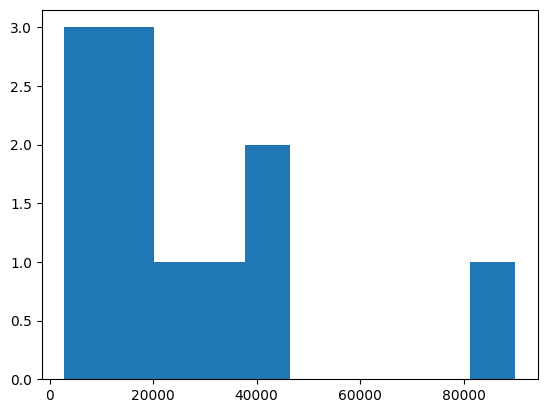

count     7.000000
mean     25.000000
std      21.809784
min       7.000000
25%       8.500000
50%      19.000000
75%      37.500000
max      57.000000
Name: age, dtype: float64


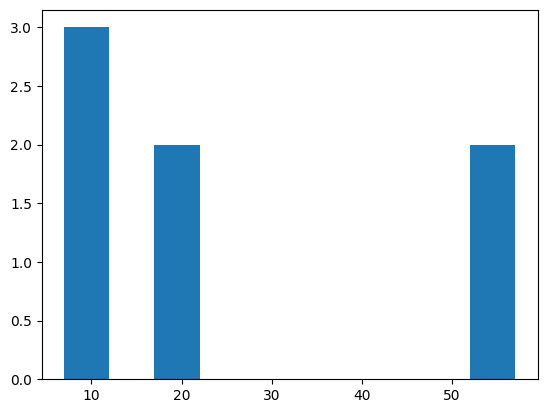

In [21]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [22]:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                              \
          count      mean           std      min      25%      50%      75%   
brand                                                                         
airstream   1.0  42500.00           NaN  42500.0  42500.0  42500.0  42500.0   
missing     8.0  22523.75  28565.577655   2800.0   9375.0  12950.0  19000.0   
roadtrek    1.0  25000.00           NaN  25000.0  25000.0  25000.0  25000.0   
thor        1.0  45000.00           NaN  45000.0  45000.0  45000.0  45000.0   

                    
               max  
brand               
airstream  42500.0  
missing    89990.0  
roadtrek   25000.0  
thor       45000.0

In [23]:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                 
          count   mean        std   min    25%   50%   75%   max
brand                                                           
airstream   1.0  20.00        NaN  20.0  20.00  20.0  20.0  20.0
missing     4.0  31.75  28.016364   7.0   7.75  31.5  55.5  57.0
roadtrek    1.0  19.00        NaN  19.0  19.00  19.0  19.0  19.0
thor        1.0   9.00        NaN   9.0   9.00   9.0   9.0   9.0

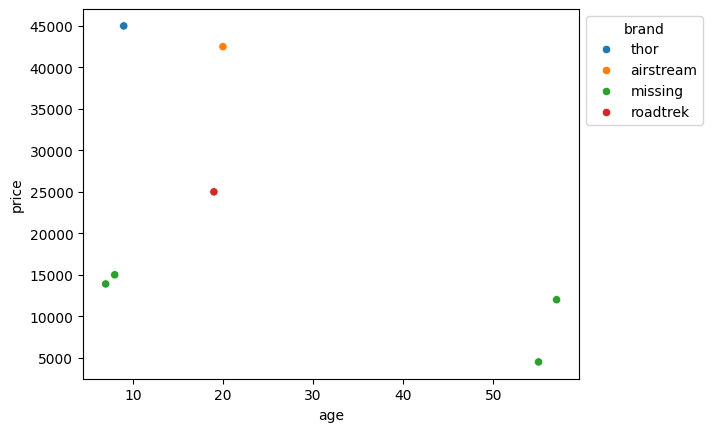

In [24]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   1.045243 -0.358506
log_age    -0.358506  0.770052
           log_price   log_age
log_price   1.000000 -0.508725
log_age    -0.508725  1.000000


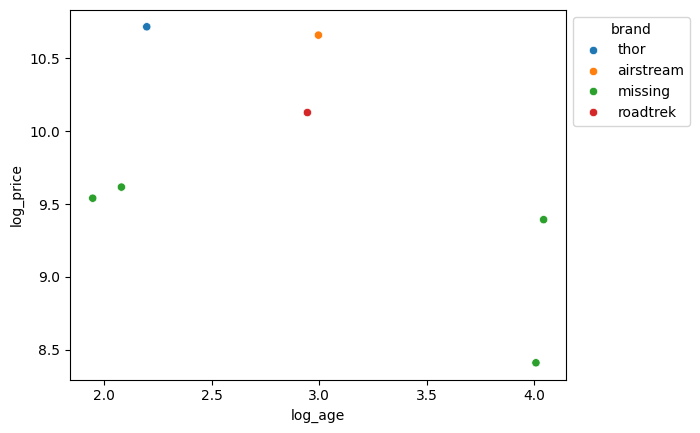

In [25]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

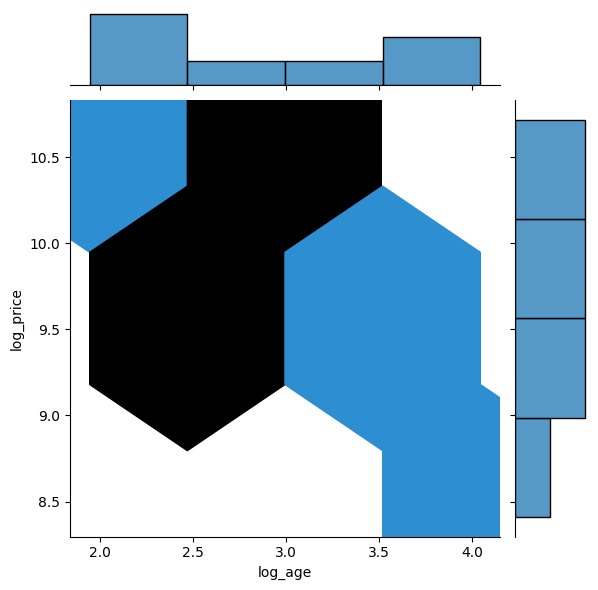

In [26]:
sns.jointplot(data=df, x='log_age', y='log_price',kind='hex')